


<font color="#d3d3d3"><h1><b>Reminder for all students and instructors to use the same version of the project notebooks (beginner or advanced)</b></h1></font>

![](http://static1.squarespace.com/static/56ccc8724c2f8548059fbcfe/58f6daea15d5dbcc64ef63aa/5cae2d770d92977242838baa/1557942174418/SW-DistractedDriving-Clean-1.jpg?format=1500w)

In this notebook we will be:
1.   Understanding and Building Neural Networks
2.   Applying Neural Networks to Detecting Distracted Drivers
3.   Exploring Convolutional Neural Networks
4.   Implementing Transfer Learning



In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121


def label_to_numpy(labels):
  final_labels = np.zeros((len(labels), 4))
  for i in range(len(labels)):
    label = labels[i]
    if label == 'Attentive':
      final_labels[i,:] = np.array([1, 0, 0, 0])
    if label == 'DrinkingCoffee':
      final_labels[i,:] = np.array([0, 1, 0, 0])
    if label == 'UsingMirror':
      final_labels[i,:] = np.array([0, 0, 1, 0])
    if label == 'UsingRadio':
      final_labels[i,:] = np.array([0, 0, 0, 1])
  return final_labels

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    metadata = metadata[keep_idx]

    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    return metadata

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.prod(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_image(data, num_ims, figsize=(8,6), labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    print(data.shape)
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(-1,image_shape[0],image_shape[1],image_shape[2])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest

    nrows=int(np.sqrt(num_ims))
    ncols=int(np.ceil(num_ims/nrows))
    print(nrows,ncols)
    count=0
    if nrows==1 and ncols==1:
      print('Label: %s'%label)
      plt.imshow(image)
      plt.show()
    else:
      print(labels)
      fig = plt.figure(figsize=figsize)
      for i in range(nrows):
        for j in range(ncols):
          if count<num_ims:
            fig.add_subplot(nrows,ncols,count+1)
            plt.imshow(image[count])
            count+=1
      fig.set_size_inches(18.5, 10.5)
      plt.show()

  # Checking correct model specs
  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))

    for layer in model.layers:
      if hasattr(layer,"activation"):
        stringlist.append(str(layer.activation))

    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  # plotting model performance
  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.25, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 7)
    ax.set_ylim([0.01, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def TransferClassifier(name, nn_params):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(1024, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(512, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(nn_params['output_neurons'],
                           activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

### defining project variables
# file variables
# image_data_url       = 'https://drive.google.com/uc?id=1qmTuUyn0525-612yS-wkp8gHB72Wv_XP'
# metadata_url         = 'https://drive.google.com/uc?id=1OfKnq3uIT29sXjWSZqOOpceig8Ul24OW'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 4
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'

### Download data
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/metadata.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/image_data.npy'

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_image = lambda data, num_ims,figsize=(8,6), labels = [], index = None: helpers.plot_image(data = data, num_ims=num_ims, figsize=figsize,labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# checking student model specs
model_to_string        = lambda model: helpers.model_to_string(model)

# models with input parameters
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

<>:217: SyntaxWarning: invalid escape sequence '\d'
<>:218: SyntaxWarning: invalid escape sequence '\d'
<>:219: SyntaxWarning: invalid escape sequence '\d'
<>:217: SyntaxWarning: invalid escape sequence '\d'
<>:218: SyntaxWarning: invalid escape sequence '\d'
<>:219: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3346057538.py:217: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d\d\d','', sms)
/tmp/ipython-input-3346057538.py:218: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d\d','', sms)
/tmp/ipython-input-3346057538.py:219: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d','', sms)


metadata.csv.1      100%[===================>] 200.33K   365KB/s    in 0.5s    
image_data.npy.1    100%[===================>] 423.61M  25.1MB/s    in 18s     


# Milestone 1. Understanding and building Neural Networks

### What are neural networks?

Just as we went over last week, neural networks look something like this:
![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)


Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction.

**In terms of this problem, what do each of the 4 blue neurons correspond to?**

## Activity 1. Building networks

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`. Let's learn how to build and use these networks!

Tensorflow calls the various machine learning algorithms that it uses 'models'.  These 'models' are 'learning machines.''

1. We **teach** models by **training** them on **data**.
2. We **use** models to **predict** things.


In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

Before we train the model or use it to predict something, we have to **create** the model.

In [ ]:
# create our model by specifying and compiling it
model_1 = Sequential()
model_1.add(Dense(4, input_shape=(3,),activation = 'relu'))
model_1.add(Dense(1, activation = 'linear'))
model_1.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The things you'll want to pay most attention to as we go over how to build networks are:
1. The number of neurons
2. The activation of the neurons
3. The losses and metrics

Everything else will work with the default settings!

Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
This line of code initializes our model! We build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we use the `add` function on our model to add a `layer` of neurons to our network.

The layer is DENSE, meaning every neuron of the current layer receives input from every neuron of the previous layer, **and** outputs information to every neuron of the next layer. This layer consists of `4` neurons. With our first `add` function, we also specify the `input_shape`, which consists of the `3` neurons in the input layer.

We also specify what kind of output, or `activation` the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use `'softmax'` or `'sigmoid'`. If you want the neuron to output any number, you can use `'linear'`! You'll also often see `'relu'`, which is when a neuron will only output positive numbers.

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it**

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some way of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary.

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```

Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data `x`, the true predictions from that data `y`, and then train our model with `fit`.

```
model.fit(x, y)
```


To use the model, you can use it to predict something with:
```
y = model.predict_classes(x)
```

You can actually use the model before you even train it! It just won't perform very well.

## Exercise (Coding): A 2-Layer Model


We're going to build this model:

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as:
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons that are activated by `'relu'`
* Layer 2 (Output): 2 neurons that are activated by `'softmax'`


We also want to compile the model with
`loss = 'categorical_crossentropy'`

In [ ]:
# Replace the None values with your group!
model_2 = Sequential()
model_2.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_2.add(Dense(2, activation = 'softmax'))

model_2.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
#@title Run this to test if your model is right!
model_2_answer = Sequential()
model_2_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_2_answer.add(Dense(2, activation = 'softmax'))
model_2_answer.compile(loss='categorical_crossentropy',
                       optimizer = 'adam',
                       metrics = ['accuracy'])

if model_to_string(model_2) == model_to_string(model_2_answer):
  print('Good job! Your model worked')
else:
  print('Please check your code again!')

Good job! Your model worked


# Milestone 2. Applying Neural Networks to Detecting Distracted Drivers

## Instructor-Led Discussion: Model Architecture


In our problem, we are given `images` of shape `(64,64,3)`, each assigned to one of 4 labels: `Attentive`, `DrinkingCoffee`, `UsingRadio`, or `UsingMirror`. We want to identify the key things that we need to design our network.

In your group, discuss:

* What are our inputs?
* What is/are our outputs?

How could this look in a neural network diagram?

**Let's discuss as a class!!**

## Activity 2b. Building our custom neural network

### Key Points

We will build a simple 2-layer network, also known as a perceptron, for our first model!


For our model, we have as our layers:
* Input Layer:  However many inputs there are!
* Layer 1 (Hidden): 128 neurons that are activated by `'relu'`
* Layer 2 (Output): 4 neurons (1 per possible predicted class) that should have an appropriate activation.
* We will compile with the `optimizers.SGD(learning_rate=1e-4, momentum=0.95)` optimizer

As a hint for the output activation and the compilation loss, we know that:
* **Binary classification** problems require an output activation of `'sigmoid'` and a loss of `'binary_cross_entropy'`
* **Multi-class classification** problems require an output activation of `'softmax'` and a loss of `'categorical_crossentropy'`
* **Linear regression** problems require an output activation of `'linear'` and a loss of `'mean_squared_error'`




###Build Your Model
Remember that a multi-layer perceptron requires flattened input, but our images have shape `(64, 64, 3)`.
We have added the `Flatten()` layer for you, which flattens our input as desired -- your job is to add the rest of the layers and compile your model!

In [ ]:
model_3 = Sequential()
model_3.add(Flatten(input_shape = (64, 64, 3)))
### FILL IN YOUR CODE HERE
model_3.add(Dense(units=128, activation = 'relu'))
model_3.add(Dense(units=4, activation = 'softmax'))
model_3.compile(loss='categorical_crossentropy',
                optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                metrics = ['accuracy'])
### END CODE

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#@title Run this to test if your model is right! { display-mode: "form" }
model_3_answer = Sequential()
model_3_answer.add(Flatten(input_shape = (64, 64, 3)))
model_3_answer.add(Dense(units = 128, activation = 'relu'))
model_3_answer.add(Dense(units = 4, activation = 'softmax'))

model_3_answer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.95),
              metrics=['accuracy'])

if model_to_string(model_3) == model_to_string(model_3_answer):
  print('Good job, you specified it correctly!')
else:
  print('Please check your code again!')

Please check your code again!


### Exercise (Coding)



## Now let's apply data augmentation to our images.

After defining our model, we often deal with the issue of a limited amount of training data in machine learning. As you might imagine, a model trained on a small set of data is likely to perform poorly because of overfitting, which means it doesn't generalize well to new, unseen data.

This is where data augmentation steps in. By creating modifications of our training data, we can artificially increase its size and diversity, improving the model's performance and generalization ability.

In the case of images, we can use the `ImageDataGenerator` class from Keras. This allows us to make random transformations to our images, such as rotations, translations, zooms, and flips, so that our model can learn from a wider range of data.

Here's how we use it:

```python
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
```
With this setup:
- `rotation_range=10`: our image will be randomly rotated between 0 and 10 degrees.
- `width_shift_range=0.1` and `height_shift_range=0.1`: our image will be moved up to 10% horizontally and vertically.
- `shear_range=0.2`: a shear (stretching) transformation will be randomly applied up to 20%.
- `zoom_range=0.2`: our image will be randomly zoomed up to 20%.
- `horizontal_flip=True`: our image can be flipped horizontally.
- `fill_mode='nearest'`: any new pixels created by these transformations will be filled with the 'nearest' color in the original image.

**It's time to use the augmented data to train our model!**

## Let's now train our perceptron on images from the train data!

Unlike the models that we used in sklearn, our neural networks are pretty finnicky. Their performance depends a lot on *how much* they train. As we'll see, they usually get better with more training BUT actually can get worse with too much training. With too much training, our model can memorize the training data (overfitting), and so doesn't actually think (generalize) when it is tested.

The extra options in our `fit()` function pertain to how the neural networks train. Don't worry too much about the extra options, what really matters for us is that the right data is specified.

To use `fit`, we use the following code:
```
X_train, y_train = get_train_data()
history = our_model.fit(data_augmentation.flow(X_train, y_train, batch_size=32), epochs = 10, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
```
What are all these options?
* `epochs`: how many times the model trains on the entire data set
* `shuffle`: mixes the training dataset so the model pays better attention to the data and learns better while training
* `validation_data`: we request that our model tests itself on the `test_data` after every epoch. Since our model is finnicky, instead of testing our model at the end of the training, we test it throughout.

 `history` gives us a data structure which allows us to plot the training and validation accuracy over time.

We have one more option too:
* `callbacks`: With a custom command, we tell our model to save the best version of itself to a model file called `model.h5`.


**Specifically, load in the training and testing data and then train your MLP model.**

_Note: Remember you already created your model above (model_3)._


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define our monitor. Don't worry about the parameters here except for './model.h5',
# which is the file that our model saves to.
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0,
                          save_best_only=True, save_weights_only=False,
                          mode='auto', save_freq='epoch')

# Create an instance of ImageDataGenerator for data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=10,  # Rotate images randomly up to 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by a fraction of the width
    height_shift_range=0.1,  # Shift images vertically by a fraction of the height
    shear_range=0.2,  # Apply shear transformation with a shear angle up to 20 degrees
    zoom_range=0.2,  # Randomly zoom images by a factor up to 20%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in newly created pixels after rotation or shifting
)

### YOUR CODE HERE (get the train data and test data!)
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()
### END CODE

# Reshape the data
X_train = X_train.reshape([-1, 64, 64, 3])
X_test = X_test.reshape([-1, 64, 64, 3])

# Convert string labels into numpy arrays.
y_train = label_to_numpy(y_train)
y_test = label_to_numpy(y_test)

### YOUR CODE HERE (fit your model!)
history = model_3.fit(data_augmentation.flow(X_train, y_train, batch_size=32), epochs = 40, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
### END CODE


Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2979 - loss: 1.3905

211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.2982 - loss: 1.3902 - val_accuracy: 0.3207 - val_loss: 1.3111
Epoch 2/40
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4030 - loss: 1.2832

211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4031 - loss: 1.2832 - val_accuracy: 0.3989 - val_loss: 1.2387
Epoch 3/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4141 - loss: 1.2561 - val_accuracy: 0.3174 - val_loss: 1.3194
Epoch 4/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4841 - loss: 1.1826 - val_accuracy: 0.3946 - val_loss: 1.3191
Epoch 5/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.4860 - loss: 1.1757 - val_accuracy: 0.3565 - val_loss: 1.3287
Epoch 6/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.4954 - loss: 1.1571 - val_accuracy: 0.3783 - val_loss: 1.3148
Epoch 7/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.4987 - loss: 1.1338 - val_accuracy: 0.4261 - val_loss: 1.3098
Epoch 8/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5252 - loss: 1.1129 - val_accuracy: 0.3913 - val_loss: 1.3801
Epoch 9/40
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5384 - loss: 1.0896

211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.5385 - loss: 1.0896 - val_accuracy: 0.5033 - val_loss: 1.2223
Epoch 10/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.5313 - loss: 1.0937 - val_accuracy: 0.4283 - val_loss: 1.3127
Epoch 11/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5725 - loss: 1.0450 - val_accuracy: 0.4663 - val_loss: 1.2492
Epoch 12/40
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5707 - loss: 1.0402

211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5708 - loss: 1.0400 - val_accuracy: 0.4772 - val_loss: 1.1998
Epoch 13/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5760 - loss: 1.0288 - val_accuracy: 0.4152 - val_loss: 1.2752
Epoch 14/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5952 - loss: 0.9998 - val_accuracy: 0.4522 - val_loss: 1.2294
Epoch 15/40
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6134 - loss: 0.9750

211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6133 - loss: 0.9751 - val_accuracy: 0.4902 - val_loss: 1.1799
Epoch 16/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.5939 - loss: 0.9879 - val_accuracy: 0.4978 - val_loss: 1.2642
Epoch 17/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6155 - loss: 0.9540

211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6155 - loss: 0.9541 - val_accuracy: 0.5109 - val_loss: 1.1152
Epoch 18/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6284 - loss: 0.9475 - val_accuracy: 0.3761 - val_loss: 1.4444
Epoch 19/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6315 - loss: 0.9449 - val_accuracy: 0.4467 - val_loss: 1.3019
Epoch 20/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6340 - loss: 0.9255 - val_accuracy: 0.4576 - val_loss: 1.1622
Epoch 21/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6580 - loss: 0.8988 - val_accuracy: 0.5022 - val_loss: 1.2322
Epoch 22/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6465 - loss: 0.9038 - val_accuracy: 0.4728 - val_loss: 1.2183
Epoch 23/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6360 - loss: 0.9189 - val_accuracy: 0.5000 - val_loss: 1.2179
Epoch 24/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6596 - loss: 0.8830 - val_accuracy

211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6727 - loss: 0.8340 - val_accuracy: 0.5924 - val_loss: 1.0794
Epoch 31/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6728 - loss: 0.8392 - val_accuracy: 0.6076 - val_loss: 1.0930
Epoch 32/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6733 - loss: 0.8080 - val_accuracy: 0.4978 - val_loss: 1.2132
Epoch 33/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6830 - loss: 0.8055 - val_accuracy: 0.5685 - val_loss: 1.1287
Epoch 34/40
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6995 - loss: 0.7884

211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6995 - loss: 0.7884 - val_accuracy: 0.5435 - val_loss: 1.0596
Epoch 35/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7063 - loss: 0.7811 - val_accuracy: 0.4880 - val_loss: 1.2451
Epoch 36/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7043 - loss: 0.7753 - val_accuracy: 0.5380 - val_loss: 1.0986
Epoch 37/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7164 - loss: 0.7731 - val_accuracy: 0.4978 - val_loss: 1.4684
Epoch 38/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7019 - loss: 0.7812 - val_accuracy: 0.5326 - val_loss: 1.1053
Epoch 39/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7095 - loss: 0.7668 - val_accuracy: 0.5772 - val_loss: 1.1381
Epoch 40/40
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7002 - loss: 0.7649 - val_accuracy: 0.5326 - val_loss: 1.0925


As our model trained, it told us a few things. The most important things to us are:
* how accurate it was when training on the training set (reported as `acc`)
* how accurate it was on the test set (reported as `val_acc`)


We can actually plot how how well our model did across epochs using the model's `history`!
To do this, we call:
```
plot_acc(history)
```

Try `plot_acc` below!

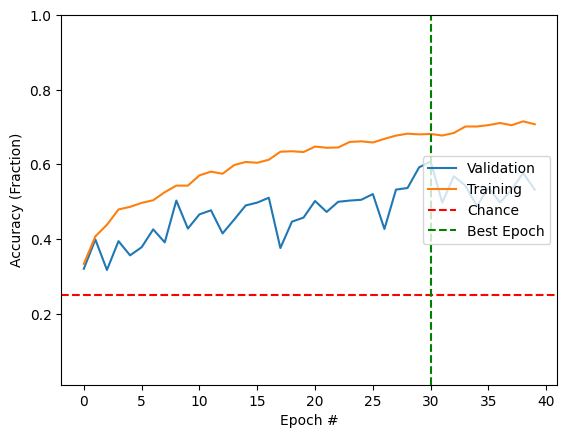

In [ ]:
### YOUR CODE HERE
plot_acc(history)
### END CODE

## Instructor-Led Discussion

Is this a good model? Does your model overfit? How do you know?

# Milestone 3. Exploring Convolutional Neural Networks

So, how is a convolutional neural network specified in tensorflow/keras? Let's walk through this!

### Exercise (Coding)


Our convolutional neural network is specified via:

```
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(__, __, __)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = NUM_OUTPUTS, activation = 'softmax'))
```

And compiled with:

```
cnn.compile(loss=__, optimizer=__, metrics=__)
```

We see that we have 1 convolution layer that takes in our inputs, and then 2 dense layers. Overall this is a 3 layer network.

After specifying the network, we can compile it and train it just like before! Note:
* we want our `loss` to be `'categorical_crossentropy'`
* our `optimizer` will be  `optimizers.SGD(learning_rate=1e-3, momentum=0.95)`
* our `metrics` are `['accuracy']`

In [ ]:
### YOUR CODE HERE - build and compile your cnn (hint: see above and fill in the blanks!)
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(64, 64, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 64, activation = 'relu'))
cnn.add(Dense(units = 4, activation = 'softmax'))
cnn.compile(loss='categorical_crossentropy',
            optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.95),
            metrics=['accuracy'])
### END CODE

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Once we've compiled the network, train it for about 50 epochs (Or less, it's up to you!).
Remember how you did this for the MLP (`model_2`)? Also, don't forget to use data augmentation!



In [ ]:
### YOUR CODE HERE
cnn.fit(data_augmentation.flow(X_train, y_train, batch_size=32), epochs = 50, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
### END CODE

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.3038 - loss: 1.3611 - val_accuracy: 0.3641 - val_loss: 1.3463
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.4550 - loss: 1.2101 - val_accuracy: 0.3370 - val_loss: 1.3690
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5447 - loss: 1.0681 - val_accuracy: 0.4511 - val_loss: 1.4028
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.5779 - loss: 0.9867 - val_accuracy: 0.5261 - val_loss: 1.4403
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6148 - loss: 0.9166 - val_accuracy: 0.6174 - val_loss: 1.3155
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6512 - loss: 0.8575 - val_accuracy: 0.6272 - val_loss: 1.3738
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.6887 - loss: 0.7932 - val_accuracy: 0.5511 - val_loss: 1.6456
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7172 - loss: 0.7358 - val_accuracy: 0.61

And see how well it did! Let's visualize the training and validation accuracy again.

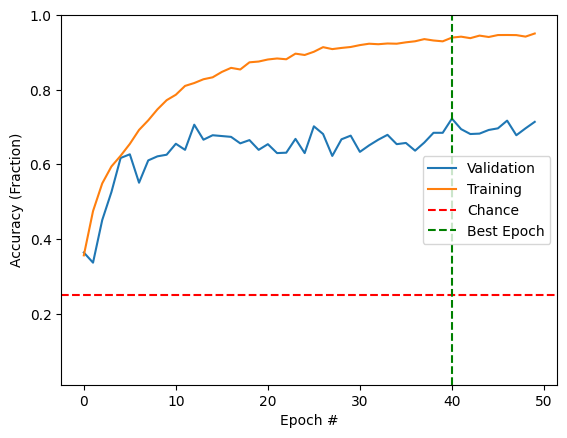

In [ ]:
### YOUR CODE HERE
plot_acc(cnn.history)
### END CODE

**Nice training accuracy! Does the model still overfit?**

*(Optional:)* Re-initialize your CNN and train it on a smaller number of epochs. What do you observe?


# Milestone 4. Expert models: Transfer learning

So far, we've used models that were built from 'scratch'. Unfortunately, our training data is small relative to the amount of data available in the real world, so just training on our dataset is going to be inherently limited.

Luckily, there are **expert models**, or state-of-the-art models that have been trained by the world's top researchers! While these expert models haven't trained on our training data, they have trained extensively on larger datasets. We can input our data and reasonably expect that they will pick up our task fairly quickly.

In deep learning, the idea of using a model trained on another task as a starting point for your model is known as **transfer learning**.

## Activity 4a. Transfer Learning for Distracted Driving


### Instructor-Led Discussion

For our transfer learning, we're going to use expert models built upon the famous 'ImageNet' classification problem.

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available.

Below, we see examples of 4 different categories.

![](http://cs231n.github.io/assets/trainset.jpg)



One of the experts we can use is VGG16. VGG16 is a specific convolutional neural network that was allowed to study the 14 million images 74 times. *(Read more about VGG16 [here!](https://neurohive.io/en/popular-networks/vgg16/))*

After training, VGG16 was able to guess something close to the real label (top-5 accuracy) better than a human can.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We're going to take an expert model like VGG16 and let it train on OUR images. Hopefully, its experience training on those 14 million images will help it understand distracted driving!

### Exercise (Coding) | Within a student group

Let's tap an expert model to help us out with our distracted driving prediction!

We provide a wrapper that lets you 'call' up and employ expert models. You can call it like...

```
transfer = TransferClassifier(name = 'VGG16')
```

The wrapper will also add a few new layers to the model that can learn specifics about **our task**.


The experts we have on hand are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`



Afterwards, see if you can get 85% accuracy with your model! Try it with and without data augmentation and see how different it preforms.

In [ ]:
# As always, we get our data first
(X_train, y_train) = get_train_data(flatten=True)
(X_test, y_test) = get_test_data(flatten=True)

X_train = X_train.reshape([-1, 64, 64, 3])
X_test = X_test.reshape([-1, 64, 64, 3])

y_train = label_to_numpy(y_train)
y_test = label_to_numpy(y_test)

### YOUR CODE HERE
transfer = TransferClassifier(name = 'VGG19')
transfer.fit(data_augmentation.flow(X_train, y_train, batch_size=32), epochs = 10, validation_data = (X_test, y_test), shuffle = True, callbacks = [monitor])
plot_acc(transfer.history)
### END CODE

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2985 - loss: 1.3918

211/211 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - accuracy: 0.2989 - loss: 1.3913 - val_accuracy: 0.4967 - val_loss: 1.1509
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7207 - loss: 0.6912

211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.7210 - loss: 0.6905 - val_accuracy: 0.6337 - val_loss: 0.8276
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9062 - loss: 0.2970

211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.9062 - loss: 0.2969 - val_accuracy: 0.7967 - val_loss: 0.5833
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9343 - loss: 0.1983

211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9343 - loss: 0.1983 - val_accuracy: 0.8478 - val_loss: 0.4468
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9465 - loss: 0.1568 - val_accuracy: 0.8228 - val_loss: 0.5537
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9644 - loss: 0.1218 - val_accuracy: 0.8217 - val_loss: 0.7662
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9652 - loss: 0.1169 - val_accuracy: 0.8370 - val_loss: 0.6437
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.9771 - loss: 0.0821 - val_accuracy: 0.8098 - val_loss: 0.6010
Epoch 9/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.9683 - loss: 0.1062 - val_accuracy: 0.8380 - val_loss: 0.7919
Epoch 10/10
 92/211 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.9722 - loss: 0.0815


## (Optional) Activity 4b. Transfer learning in tensorflow/keras

If you want to see how to implement transfer learning in tensorflow/keras, you can try this exercise!


### Exercise (Coding) | Within a student group


First, let's import VGG16's architecture from `tensorflow.keras`.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

Let's now load up VGG16. We only want the convolutional layers of the model - that is, the layers that are most responsible for giving the model its visual understanding. The 'Dense/Fully Connected (FC)' layers are thought to be more specific to the ImageNet challenge.

In [ ]:
# Load the VGG architecture but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

Now, we're going to plug the VGG into a custom model. to do this, we do the following:

In [ ]:
# We add the first 12 layers of VGG to our own model: vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

NameError: name 'Sequential' is not defined

We want to add custom layers to our model... specifically,
* `GlobalAveragePooling2D() # helps our vgg expert`
* `Dense(1024, activation = 'relu') # we've seen dense before!`
* `Dropout(0.3) # we've experimented with dropout before!`
* `Dense(512, activation = 'relu')`
* `Dropout(0.3)`
* `Dense(4, activation = 'softmax') # our output layer!`

### Instructor-Led Discussion: Why do we add these layers to the end of the network?

In [ ]:
# Then we add our own layers on top of our vgg_model
### YOUR CODE HERE

### END CODE

And finally compile it with
* loss: `categorical_crossentropy`
* optimizer: `optimizers.SGD(learning_rate = 1e-4, momentum = 0.95)`
* metrics: `accuracy`


In [ ]:
# Compile our model
### YOUR CODE HERE

### END CODE

Finally, train your model on the `training data`.


In [ ]:
### YOUR CODE HERE

### END CODE

Use `plot_acc()` to visualize how your model did!

In [ ]:
### YOUR CODE HERE

### END CODE

## Nice! Hopefully your transfer learning model did much better on the validation data set.

![](http://static1.squarespace.com/static/56ccc8724c2f8548059fbcfe/58f6daea15d5dbcc64ef63aa/5cae2d770d92977242838baa/1557942174418/SW-DistractedDriving-Clean-1.jpg?format=1500w)